# Titanic Competition

In [2]:
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|##########| 34.1k/34.1k [00:00<00:00, 17.1MB/s]


In [3]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Preparation

In [5]:
import numpy as np
import pandas as pd 

## Exploratory Data Analysis

In [38]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [104]:
test_data.isnull().sum() #checking for Null values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
AgeRange        91
FareCat          0
dtype: int64

<AxesSubplot:>

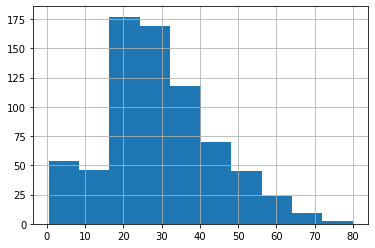

In [62]:
train_data.Age.hist()

In [ ]:
mean_age_train = train_data

In [111]:
age_filter = lambda x: 0 if x < 18 else 1 if (x >= 18 and x < 30) else 2 if (x >= 30 and x < 50) else 3 if x >= 50 else 4 if np.isnan(x) else None
train_data['AgeRange'] = train_data['Age'].apply(age_filter).astype(int)
test_data['AgeRange'] = test_data['Age'].apply(age_filter).astype(int)

In [112]:
fare_filter = lambda x: 0 if x < 25 else 1 if x >= 25 else None
train_data['FareCat'] = train_data['Fare'].apply(fare_filter).astype(int)
test_data['FareCat'] = test_data['Fare'].apply(fare_filter).astype(int)

In [108]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
AgeRange         0
FareCat          0
dtype: int64

In [127]:
features = ["Pclass", "Sex", "SibSp", "Parch","Embarked","AgeRange","FareCat"]
X = pd.get_dummies(train_data[features].astype('str'))
X_test = pd.get_dummies(test_data[features].astype('str'))

In [130]:
X.drop("Embarked_nan",axis=1,inplace=True)

In [132]:
X.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0',
       'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8',
       'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5',
       'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'AgeRange_0',
       'AgeRange_1', 'AgeRange_2', 'AgeRange_3', 'AgeRange_4', 'FareCat_0',
       'FareCat_1'],
      dtype='object')

In [134]:
X_test.drop("Parch_9",axis=1,inplace=True)

In [135]:
X_test.columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0',
       'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8',
       'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5',
       'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'AgeRange_0',
       'AgeRange_1', 'AgeRange_2', 'AgeRange_3', 'AgeRange_4', 'FareCat_0',
       'FareCat_1'],
      dtype='object')

## Model Training

In [139]:
import xgboost as xgb

y = train_data["Survived"]

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X, y)
predictions = xgb_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [145]:
from sklearn.metrics import accuracy_score

y_pred = xgb_model.predict(X)

print("Accuracy of Model::",accuracy_score(y,y_pred))
 


Accuracy of Model:: 0.8765432098765432


In [147]:
y_pred2 = clf.predict(X)

print("Accuracy of Model::",accuracy_score(y,y_pred2))


Accuracy of Model:: 0.8787878787878788


In [140]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
predictions = clf.predict(X_test)

In [142]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

### Check accuracy on training set

In [126]:
output_old = output.copy()

## Hyperparameter Tuning

In [138]:
output == output_old

,PassengerId,Survived
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
413,True,True
414,True,True
415,True,True
416,True,True


## Ensembling

## Predictions

In [ ]:
# Prediction of target for test data
preds = model.predict(test_data).astype(int)

# Saving the result into submission file
submission = pd.read_csv('gender_submission.csv')
submission["Survived"] = preds
submission.to_csv('submission.csv', index=False)